# Influence function - standard error

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import random
import math
import scipy
from scipy import stats
from random import choice
import networkx as nx
import json
from networkx.readwrite import json_graph
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [2]:
import findspark
import os
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [4]:
# Load network graph
with open("graph/nc_full.json", "r") as graph_data:
    graph_data = json.load(graph_data)
    NC_digraph = json_graph.node_link_graph(graph_data)

### Calculate variance of simulation results

In [12]:
def influenceFunction(detStartNodes, t=999999):

    explored = set()
    activated = set()
    nodes = []
    detStart = random.choice(NC_digraph.nodes(), 1)[0]
    nodes.append(detStart)
    activated.add(detStart)
    
    start = detStart
    successors = []

    for i in range(t):
        successors = []
        while len(nodes)>0:
            startNode = nodes[0]
            if startNode not in explored:
                explored.add(startNode)
            for succNode in NC_digraph.succ[startNode]:
                if succNode not in activated:
                    alpha = NC_digraph[startNode][succNode]['weight']
                    beta = NC_digraph.node[succNode]['review_count']
                    if random.uniform(0,1) < np.sqrt(random.beta(alpha, beta)):
                        if succNode not in explored:
                            activated.add(succNode)
                            successors.append(succNode)
            nodes.remove(startNode)
        nodes = successors
        if not nodes:
            break
    return len(activated)

In [13]:
def influenceFunctionNotPar(N, t=999999):
    result = []
    for n in xrange(N):
        result.append(float(influenceFunction(t)))
    return np.mean(result)

**Plot standard error as a function of N:**

In [16]:
plot_range = [100,250,500,750,1000]

In [17]:
for k in plot_range: 
    print k
    runs = sc.parallelize(range(100), 4)
    results = runs.map(lambda x: influenceFunctionNotPar(k))
    results_list = results.collect()
    fd = open("SE-NC_full-N=" + str(k) + ".json","w")
    json.dump(results_list, fd)
    fd.close()
    del results

100
250
500
750
1000


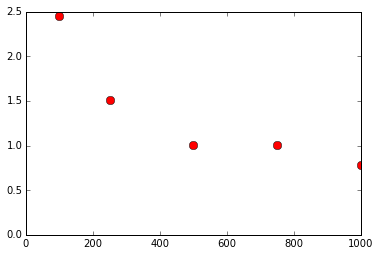

In [10]:
stdErr = dict()

for k in plot_range:

    with open("SE-NC_full-N=" + str(k) + ".json", "r") as fd:
        results = json.load(fd)
        
    stdErr[k] = np.std(results)
    
plt.plot(stdErr.keys(), stdErr.values(), 'o-', color='r', linestyle='None', markersize=8)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

In [11]:
y = [math.log(i) for i in stdErr.values()]
x = [math.log(i) for i in stdErr.keys()]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

In [12]:
print 'lambda = %f' % (-slope)
print 'alpha = %f' % (math.exp(intercept))

lambda = 0.479969
alpha = 21.769997


Check results with log-plot:

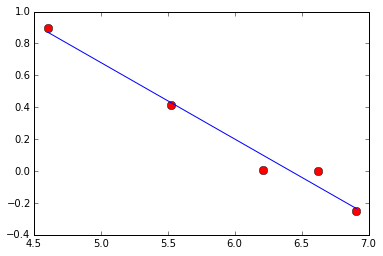

In [13]:
keys = [math.log(i) for i in stdErr.keys()]
keys.sort()
solution = [intercept + slope*n for n in keys]

plt.plot(x, [math.log(i) for i in stdErr.values()], 'o-', color='r', linestyle='None', markersize=8)
plt.plot(keys, solution)
# plt.xlim(xmin=4)
# plt.ylim(ymin=-1)
plt.show()